In [1]:
import os
from pdf2image import convert_from_path
import glob
import shutil
import cv2
import torch
import matplotlib.pyplot as plt
import pytesseract
import pandas as pd
from transformers import pipeline
import numpy as np
from PIL import Image
from IPython.display import display
import re
import spacy
from spacy.training import Example

!apt-get install -y poppler-utils

2024-07-31 14:21:41.647165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 14:21:41.647314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 14:21:41.757299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpoppler97 poppler-data
Suggested packages:
  ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  libpoppler97 poppler-data poppler-utils
0 upgraded, 3 newly installed, 0 to remove and 80 not upgraded.
Need to get 2564 kB of archives.
After this operation, 16.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 poppler-data all 0.4.9-2 [1475 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libpoppler97 amd64 0.86.1-0ubuntu1.4 [916 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 poppler-utils amd64 0.86.1-0ubuntu1.4 [174 kB]
Fetched 2564 kB in 1s (2110 kB/s)       
Selecting previously unselected package

In [2]:
# Step 1: Convert PDFs to High-Resolution Images
def convert_pdfs_to_images(pdf_folder, output_folder, dpi=500):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    all_image_paths = []
    pdf_files = glob.glob(os.path.join(pdf_folder, '*.pdf'))
    
    for pdf_path in pdf_files:
        images = convert_from_path(pdf_path, dpi=dpi)
        pdf_name = os.path.basename(pdf_path).replace('.pdf', '')
        for i, image in enumerate(images):
            image_path = os.path.join(output_folder, f'{pdf_name}_page_{i}.png')
            image.save(image_path, 'PNG')
            all_image_paths.append(image_path)
    
    return all_image_paths

pdf_folder = "/kaggle/input/dataset"  # Update with your PDF folder path
output_folder = 'images'
image_paths = convert_pdfs_to_images(pdf_folder, output_folder)
print(f'Converted PDFs to {len(image_paths)} images.')

label_folder = '/kaggle/input/labels'  # Update with your label folder path
label_paths = [os.path.join(label_folder, label) for label in os.listdir(label_folder)]

Converted PDFs to 100 images.


In [3]:
# Ensuring image_paths and label_paths correspond
image_paths = sorted(image_paths, key=lambda x: os.path.basename(x))
label_paths = sorted(label_paths, key=lambda x: os.path.basename(x))

In [4]:
# Step 3: Prepare YOLO Dataset
def prepare_yolo_dataset(image_paths, label_paths, output_dir):
    # Define the directories
    train_images_dir = os.path.join(output_dir, 'train', 'images')
    train_labels_dir = os.path.join(output_dir, 'train', 'labels')
    val_images_dir = os.path.join(output_dir, 'val', 'images')
    val_labels_dir = os.path.join(output_dir, 'val', 'labels')
    test_images_dir = os.path.join(output_dir, 'test', 'images')
    test_labels_dir = os.path.join(output_dir, 'test', 'labels')

    # Create the directories if they don't exist
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)
    os.makedirs(test_images_dir, exist_ok=True)
    os.makedirs(test_labels_dir, exist_ok=True)

    # Determine the split ratios
    num_images = len(image_paths)
    num_train = int(0.7 * num_images)
    num_val = int(0.2 * num_images)

    # Split the data into train, val, and test sets
    for i, (image_path, label_path) in enumerate(zip(image_paths, label_paths)):
        if i < num_train:
            shutil.copy(image_path, os.path.join(train_images_dir, os.path.basename(image_path)))
            shutil.copy(label_path, os.path.join(train_labels_dir, os.path.basename(label_path)))
        elif i < num_train + num_val:
            shutil.copy(image_path, os.path.join(val_images_dir, os.path.basename(image_path)))
            shutil.copy(label_path, os.path.join(val_labels_dir, os.path.basename(label_path)))
        else:
            shutil.copy(image_path, os.path.join(test_images_dir, os.path.basename(image_path)))
            shutil.copy(label_path, os.path.join(test_labels_dir, os.path.basename(label_path)))

    return train_images_dir, train_labels_dir, val_images_dir, val_labels_dir, test_images_dir, test_labels_dir

# Example usage
output_dir = 'yolo_dataset'
train_images_dir, train_labels_dir, val_images_dir, val_labels_dir, test_images_dir, test_labels_dir = prepare_yolo_dataset(image_paths, label_paths, output_dir)


In [26]:
# #Step 4: Clone YOLOv5 repository and install dependencies
# !git clone https://github.com/ultralytics/yolov5
# %cd yolov5
# !pip install -r requirements.txt

# Create data.yaml file
data_yaml_content = """
train: /kaggle/working/yolo_dataset/train/images
val: /kaggle/working/yolo_dataset/val/images

nc: 15

names: ['Invoice', 'Bill To', 'Ship To', 'Date', 'Ship Mode', 'Balance Due', 'Item', 'Quantity', 'Rate', 'Amount', 'Subtotal', 'Discount', 'Shipping', 'Total', 'OrderId']

class_weights: [1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 45, 10, 1, 1]
"""

with open('/kaggle/working/yolov5/data.yaml', 'w') as f:
    f.write(data_yaml_content)

In [27]:
# customize  ipython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    try:
        with open(line.strip(), 'w') as f:
            f.write(cell.format(**globals()))
        print(f"File written: {line.strip()}")
    except Exception as e:
        print(f"Error writing file: {e}")


In [28]:
%%writetemplate /kaggle/working/yolov5/models/custom_yolov5m.yaml

# Ultralytics YOLOv5 🚀, AGPL-3.0 license

# Parameters
nc: 15 # number of classes
depth_multiple: 0.67 # model depth multiple
width_multiple: 0.75 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
  ]


File written: /kaggle/working/yolov5/models/custom_yolov5m.yaml


In [29]:
# Step 5: Train the YOLO model
!python train.py --img 640 --batch 8 --epochs 100 --data /kaggle/working/yolov5/data.yaml --cfg /kaggle/working/yolov5/models/custom_yolov5m.yaml --weights yolov5m.pt --cache

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-07-31 14:40:46.851482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 14:40:46.851540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 14:40:46.853073: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train:

In [31]:
# Step 6: Load the trained model and predict bounding boxes
custom_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/kaggle/working/yolov5/runs/train/exp/weights/best.pt')

def predict_bboxes(image_path, model):
    results = model(image_path)
    results = results.xyxy[0]  # x1, y1, x2, y2, confidence, class
    # Filter out low-confidence predictions
    results = results[results[:, 4] > 0.25]  # 0.5 confidence threshold
    return results

def plot_and_save_bboxes(image_path, bboxes, output_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    print("Image loaded and converted to RGB.")

    # Plot the bounding boxes
    for bbox in bboxes:
        x1, y1, x2, y2, conf, cls = bbox
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        label = f"{int(cls)}: {conf:.2f}"
        
        # Draw the rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Put the label above the rectangle
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Save the image with bounding boxes
    output_image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
    cv2.imwrite(output_path, output_image_bgr)
    print(f"Image saved with bounding boxes at: {output_path}")

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-7-31 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
custom_YOLOv5m summary: 212 layers, 20909508 parameters, 0 gradients, 48.0 GFLOPs
Adding AutoShape... 


In [32]:
# Step 7: Test on Validation Set
val_folder = '/kaggle/working/yolo_dataset/val/images'  # Update with your label folder path
val_image_paths = [os.path.join(val_folder, image) for image in os.listdir(val_folder)]
val_output_dir = '/kaggle/working/val_predictions1'
os.makedirs(val_output_dir, exist_ok=True)

for val_image_path in val_image_paths:
    val_output_path = os.path.join(val_output_dir, os.path.basename(val_image_path))
    predicted_bboxes = predict_bboxes(val_image_path, custom_model)
    plot_and_save_bboxes(val_image_path, predicted_bboxes, val_output_path)

Image loaded and converted to RGB.
Image saved with bounding boxes at: /kaggle/working/val_predictions1/invoice_Phillip Breyer_11502_page_0.png
Image loaded and converted to RGB.
Image saved with bounding boxes at: /kaggle/working/val_predictions1/invoice_Ralph Arnett_11001_page_0.png
Image loaded and converted to RGB.
Image saved with bounding boxes at: /kaggle/working/val_predictions1/invoice_Stuart Calhoun_20954_page_0.png
Image loaded and converted to RGB.
Image saved with bounding boxes at: /kaggle/working/val_predictions1/invoice_Phillip Breyer_11501_page_0.png
Image loaded and converted to RGB.
Image saved with bounding boxes at: /kaggle/working/val_predictions1/invoice_Roland Schwarz_26893_page_0.png
Image loaded and converted to RGB.
Image saved with bounding boxes at: /kaggle/working/val_predictions1/invoice_Sarah Brown_4375_page_0.png
Image loaded and converted to RGB.
Image saved with bounding boxes at: /kaggle/working/val_predictions1/invoice_Scot Wooten_10963_page_0.png
I

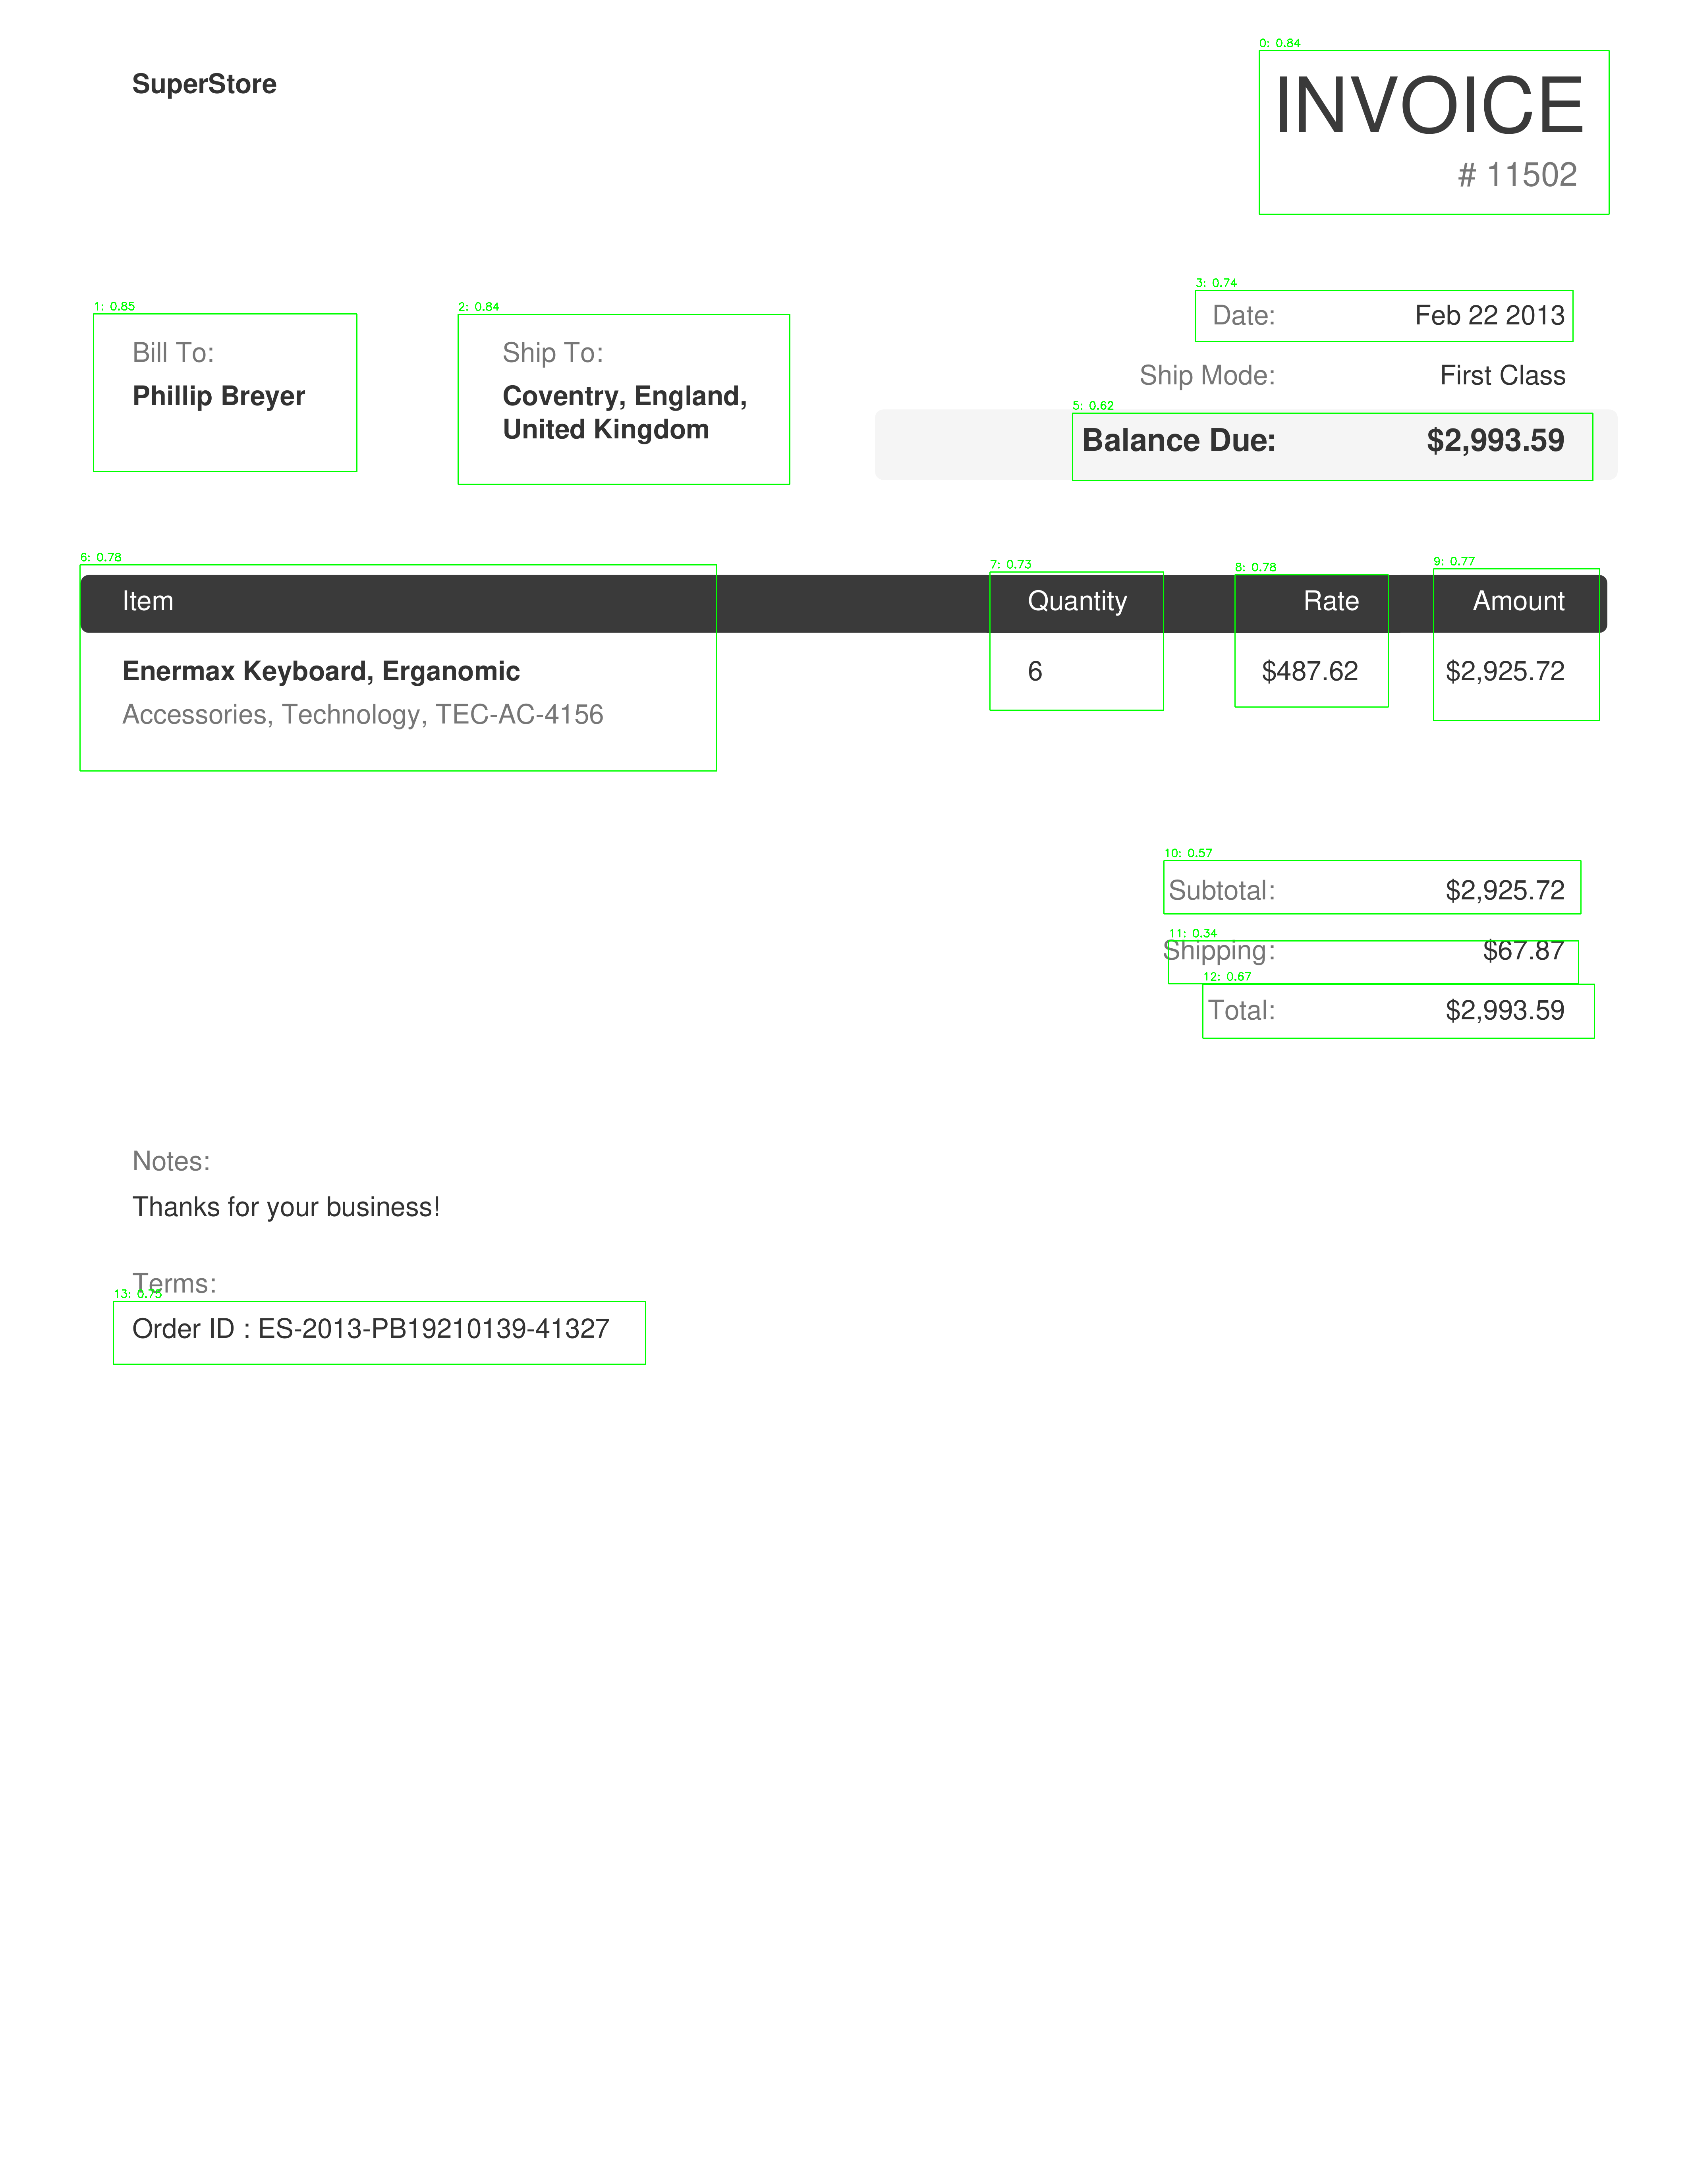

In [33]:
val_output_dir
val_image_paths = [os.path.join(val_output_dir, image) for image in os.listdir(val_output_dir)]
for image in val_image_paths:
    img = Image.open(image)
    display(img)
    break

Image loaded and converted to RGB.
Image saved with bounding boxes at: /kaggle/working/invoice_Theresa Coyne_22198_page_0.png


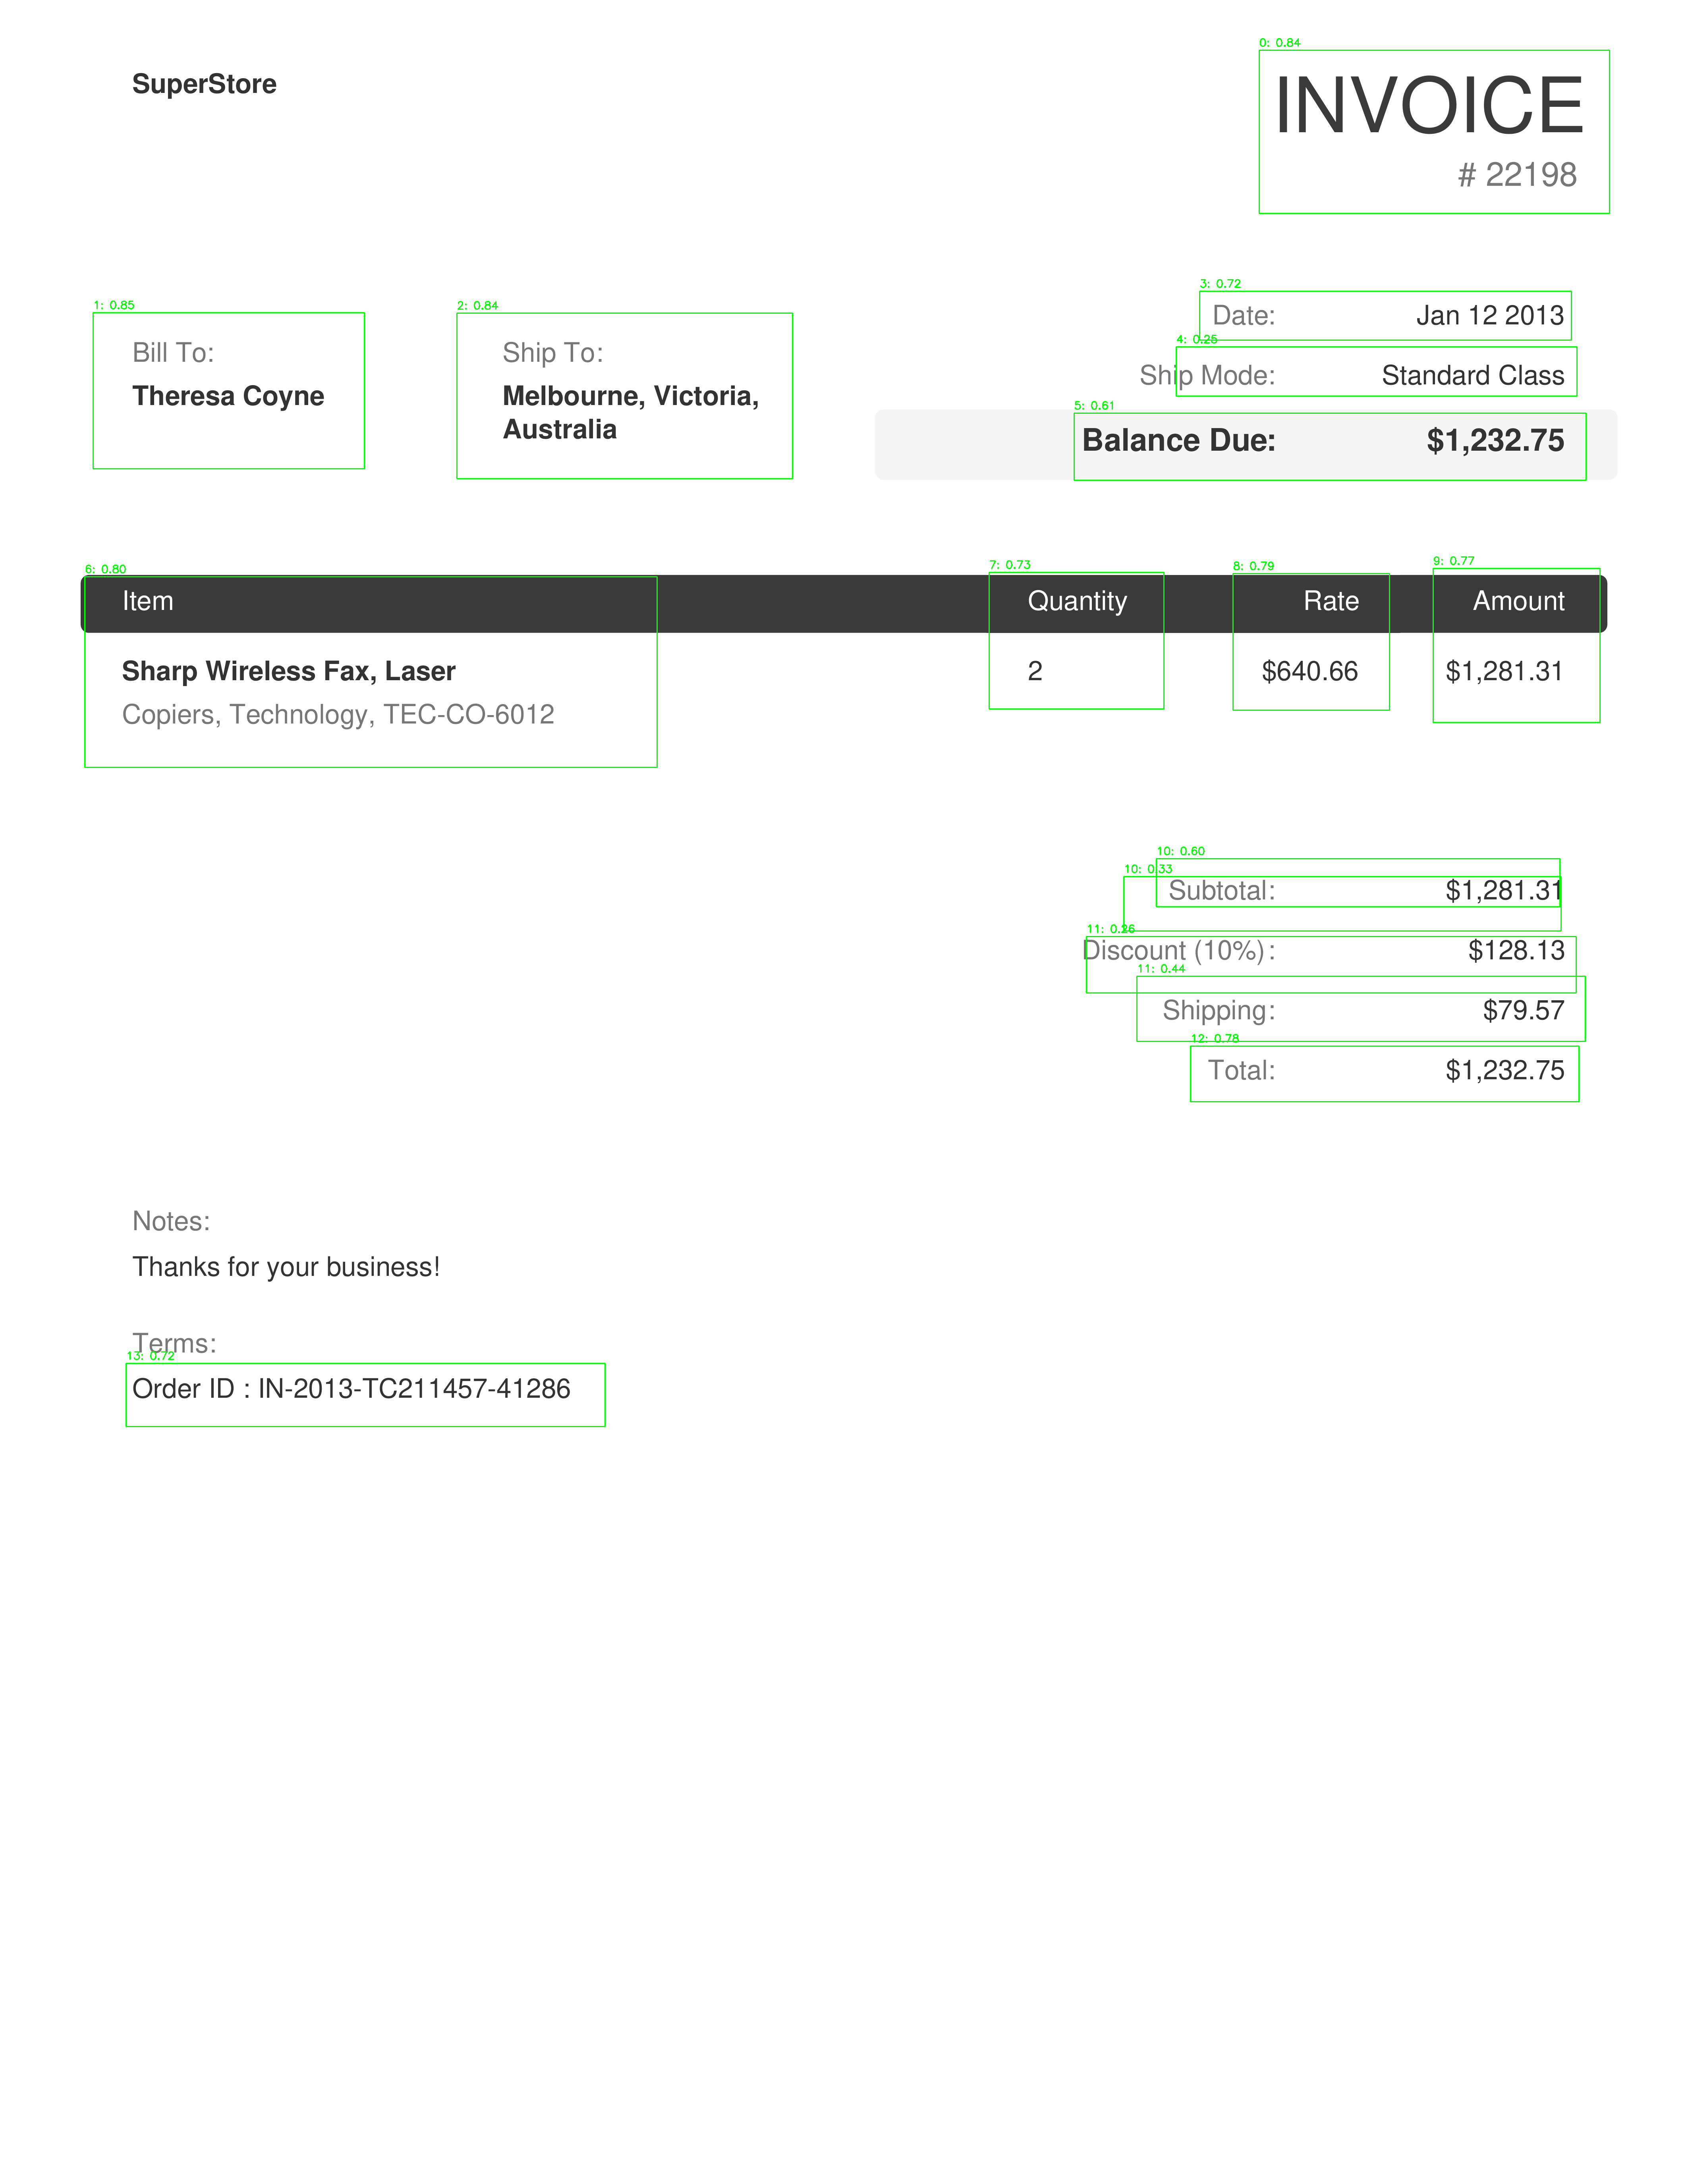

In [38]:
predicted_bboxes = predict_bboxes('/kaggle/working/yolo_dataset/test/images/invoice_Theresa Coyne_22198_page_0.png', custom_model)
plot_and_save_bboxes('/kaggle/working/yolo_dataset/test/images/invoice_Theresa Coyne_22198_page_0.png', predicted_bboxes, '/kaggle/working/invoice_Theresa Coyne_22198_page_0.png')
img = Image.open('/kaggle/working/invoice_Theresa Coyne_22198_page_0.png')
display(img)

In [34]:
def extract_text_from_bboxes(image_path, bboxes):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return []

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    extracted_texts = []

    for bbox in bboxes:
        x1, y1, x2, y2, _, _ = bbox
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        roi = image_rgb[y1:y2, x1:x2]
        text = pytesseract.image_to_string(roi)
        extracted_texts.append(text.strip())

    return extracted_texts


In [35]:
def run_inference_on_image(model, image_path, conf_thres=0.25):
    # Load the image
    image = cv2.imread(image_path)
    
    # Perform inference
    results = model(image)
    
    # Filter results by confidence threshold
    results = results.pandas().xyxy[0]  # Get results as a pandas DataFrame
    results = results[results['confidence'] >= conf_thres]
    
    # Convert YOLO results to bounding boxes
    bboxes = []
    for index, row in results.iterrows():
        x_min, y_min, x_max, y_max = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
        bboxes.append((x_min, y_min, x_max, y_max))
    
    return bboxes, results


In [37]:
def apply_clahe(image):
    if len(image.shape) == 2:  # Grayscale image
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(image)
    else:  # Color image
        ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(ycrcb)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        y = clahe.apply(y)
        clahe_ycrcb = cv2.merge([y, cr, cb])
        return cv2.cvtColor(clahe_ycrcb, cv2.COLOR_YCrCb2BGR)

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = apply_clahe(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    denoised = cv2.fastNlMeansDenoising(thresh, None, 30, 7, 21)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(denoised, -1, kernel)
    return sharpened


def extract_text_from_bboxes(image_path, bboxes):
    image = preprocess_image(image_path)
    extracted_text = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        roi = image[y_min:y_max, x_min:x_max]
        
        # Optional: Save the region of interest for debugging
        # cv2.imwrite(f'roi_{x_min}_{y_min}.png', roi)
        
        text = pytesseract.image_to_string(roi, config='--psm 6')
        extracted_text.append(text.strip())
    return extracted_text

# Main process
model = custom_model  
image_path = '/kaggle/working/yolo_dataset/test/images/invoice_Tom Ashbrook_49660_page_0.png' 

bboxes, results = run_inference_on_image(model, image_path)
extracted_text = extract_text_from_bboxes(image_path, bboxes)

# Display the extracted text for verification
for i, text in enumerate(extracted_text):
    print(f'Text {i + 1}: {text}')


Text 1: Bill To:
Tom Ashbrook
Text 2: INVOICE
Text 3: Ship To:
Silivri, Istanbul,
Turkey
Text 4: Office Star Swivel Stool, Adjustable
Chairs, Furniture, FUR-CH-5454
Text 5: $988.01
Text 6: Date: Feb 21 2013
Text 7: AmOuTR
$13,832.11
Text 8: Order ID : TU-2013-TA11385134-41326
Text 9: Total: $5,640.75
Text 10: Quantity
14
Text 11: Subtotal: $13,832.1
Text 12: Balance Due: $5,640.75
Text 13: Shipping: $107.91
Text 14: Subtotal: $13,832. 1°
Text 15: p Mode: Standard Class
Text 16: Discount (60%): $8,299.27
